##### Версия 0.1 -- Март 2018

# Обтекание цилиндра, составленного из панелей

На предыдущих занятиях для представления тел простой формы, таких как [овал Рэнкина](02_Lesson02_sourceSinkFreestream.ipynb) или [круговой цилиндр](03_Lesson03_doublet.ipynb) использовались точечные особенности, помещенные в равномерный поток. Надо сказать, это большая удача, что при помощи комбинации нескольких фундаментальных решений уравнения Лапласа удается получить картины течения, в которых разделительная линия тока выглядит как замкнутое тело.

Но что, если нужно получить картину течения вокруг произвольной геометрии? Удастся ли подобрать такую комбинацию фундаментальных решений, чтобы получился нужный результат? *И как это сделать?* Методом проб и ошибок? Потребуется невероятная удача и масса усилий, чтобы получилась необходимая геометрия.

Цель этого занятия — получить распределения положений источников и их интенсивностей, при которых создается потенциальное обтекание заданной геометрии, а именно, кругового цилиндра. Известно, что течение вокруг цилиндра моделируется при помощи комбинации диполя и равномерного потока, но нам нужно разработать общий подход к моделированию течений, который можно будет применить к *различным* геометриям.

Метод, которым мы воспользуемся, состоит в следующем Геометрия тела представляется в виде набора небольших отрезков, *панелей*, которые являются [слоями источников](08_Lesson08_sourceSheet.ipynb), изученными на прошлом занятии. 

В результате мы должны получить алгоритм, согласно которому, вначале задается геометрия объекта, а затем определяются интенсивности источников каждой панели, при которых разделительная линия тока совпадает с границей тела. Искомые значения интенсивностей определяются из условия непротекания.

Начнем с импорта необходимых библиотек.

In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

Добавим равномерный горизонтальный поток со скоростью `u_inf`, равной 1:

In [2]:
u_inf = 1.0             # free-stream speed

### Задание геометрии

Рассмотрим круговой цилиндр единичного радиуса. Такая геометрия задается множеством точек в диапазоне углов от $0$ до $2\pi$.

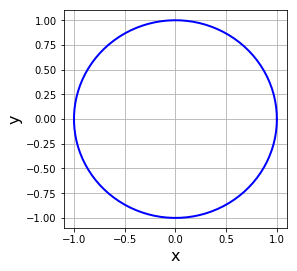

In [3]:
# define the cylinder
R = 1.0                                                     # radius
theta = numpy.linspace(0, 2*math.pi, 100)                           # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder

# plot the cylinder
size = 4
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Разбиение на панели

Панель, представляющая собой слой источников, определятся координатами начала и конца (`xa`, `ya`) и (`xb`, `yb`), и интенсивностью `sigma`. В дальнейшем нам также понадобятся ее центр (`xc`, `yc`) и длина. Положение панели определятся углом между нормалью и осью $x$. Положительным считается направление против часовой стрелки.

Что нам нужно вычислить для каждой панели? Во-первых, интенсивность слоя источников, которая нужна для получения линий тока. Во-вторых, касательную компоненту скорости на панели (нормальная компонента равна нулю) и коэффициент давления.

На этом занятии вы в полной мере оцените пользу классов. Они сильно облегчат процесс управления кодом. Создадим класс с именем `Panel`, в котором будет содержаться все геометрические данные, относящиеся к одиночной панели. Имея начальную и конечную точку, внутри класса вычислим координаты центра, длину и нормаль. Также интенсивность источника, касательная компонента скорости и коэффициент давления инициализируются нулевыми значениями. (Потом они изменятся.)

In [4]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center, length, and angle 
        (with the x-axis) of the panel.
        Initializes the strength of the source-sheet, the tangential velocity,
        and the pressure coefficient to zero.
        
        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

Для хранения разбиения создадим массив NumPy длины `N_panels`, в котором каждый элемент будет объектом класса `Panel`.

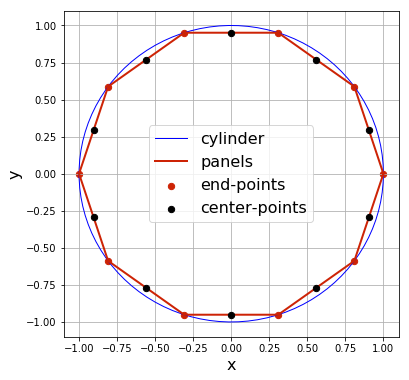

In [5]:
N_panels = 10                    # number of panels desired

# define the end-points of the panels
x_ends = R*numpy.cos(numpy.linspace(0, 2*math.pi, N_panels+1))
y_ends = R*numpy.sin(numpy.linspace(0, 2*math.pi, N_panels+1))

# define the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_cylinder, y_cylinder,
            label='cylinder',
            color='b', linestyle='-', linewidth=1)
pyplot.plot(x_ends, y_ends,
            label='panels',
            color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels],
               label='end-points',
               color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels],
               label='center-points',
               color='k', s=40, zorder=3)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.1, 1.1)
pyplot.ylim(-1.1, 1.1);

### Граничное условие для потока на поверхности тела

В заключительном задании [первого занятия(01_Lesson01_sourceSink.ipynb) вы получили потенциал скорости для одиночного источника. При интегрировании радиальной компоненты скорости $u_r=\frac{\sigma}{2\pi r}$ получим

$$\phi=\frac{\sigma}{2\pi}\ln r$$

(При интегрировании еще появляется функция от $\theta$, которая, однако, является константой, поскольку $u_{\theta}=0$; положим эту константу равной нулю.)

Мы воспользуемся потенциалом скорости, чтобы сделать вектор скорости касательным к панели. Для этого нужно, чтобы $u_n=0$, или

$$u_n(x,y)=\frac{\partial \phi}{\partial n}(x,y)$$

в заданной точке панели. Выберем в качестве точки, в которой будет обеспечиваться выполнение условия непротекания, центр панели и будем называть ее *контрольная точка*.

Потенциал скорости для [слоя источников](08_Lesson08_sourceSheet.ipynb) одиночной панели в декартовой системе координат:

$$\phi\left(x,y\right) = \frac{\sigma}{2\pi} \int_\text{panel} \ln \sqrt{ \left(x-x(s)\right)^2 + \left(y-y(s)\right)^2 } {\rm d}s$$

где $s$ — текущая координата вдоль панели, а $\left(x(s),y(s)\right)$ — декартовы координаты $s$.

Потенциал в произвольной точке $\left(x,y\right)$ есть суперпозиция потенциалов каждой панели, поэтому просуммируем вклад от кажой панели (при этом вынесем логарифм корня из-под знака интеграла): 

$$\phi\left(x,y\right) = \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

Если добавить к полученному выражению невозмущенный поток, то течние в окрестности кругового цилиндра будет иметь следующий потенциал:

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

Обеспечение касательности скорости в *контрольных точках* делает контур тела разделительной линией тока в некотором приближении, при этом точность такого приближения увеличивается по мере роста количества панелей. Так, для каждой панели $i$, в точке $(x_{c_i},y_{c_i})$ должно выполняться $u_n=0$:

$$u_{n_i} = \frac{\partial}{\partial n_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace = 0$$

что приводит к

$$0 = U_\infty \cos\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial n_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial n_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

где $\beta_i$ — угол, который нормаль к панели образует с осью $x$, так что

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos\beta_i \quad \text{and}\quad\frac{\partial y_{c_i}}{\partial n_i} = \sin\beta_i$$

и

$$x_j(s_j) = x_{a_j} - \sin\left(\beta_j\right) s_j$$
$$y_j(s_j) = y_{a_j} + \cos\left(\beta_j\right) s_j$$

Возникает проблема в случае, когда $i=j$. Из предыдущего блокнота мы знаем, что интенсивность [слоя источников](08_Lesson08_sourceSheet.ipynb) должна принимать определенное значение, чтобы линии тока не проникали через панель. Исходя из этого соображения, обозначим вклад $i$-ой панели как $\frac{\sigma_i}{2}$.

Тогда граничное условие в центре $i$-ой панели можно будет

$$0 = U_\infty \cos\beta_i + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

Из приведенного выше уравнения, мы понимаем, что нам придется вычислять интегралы с помощью SciPy функции `integrate.quad()`. Определим функцию `integral_normal()`, которая сделает за нас всю сложную работу.

In [6]:
def integral_normal(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (+(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

### Решение системы линейных уравнений

Мы только что вывели уравнение, обеспечивающее выполнение условия непротекания на $i$-ой панели. У нас `N_panels` таких панелей, а значит `N_panels` неизвестных интенсивностей $\sigma_i$. Таким образом, задача сводится к решению системы линейных уравнений:

$$[A][\sigma] = [b]$$

где

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, если } i=j \cr
\frac{1}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & \mbox{, if } i\neq j
\end{matrix}
\end{cases}$$

и

$$b_i = - U_\infty \cos\beta_i$$

для $1\leq i,j \leq N_p$. Заполним матрицу $A$ и столбец правых частей $b$ нужными значениями:

In [7]:
# compute the source influence matrix
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_normal(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.cos([p.beta for p in panels])

Вуаля! Мы только что воспользовались новой (для нас) встроенной функцией  [enumerate()](https://docs.python.org/2/library/functions.html#enumerate). С ее помощью мы получаем доступ к каждому элементу `panel` массива `panels`, отслеживая его порядковый номер `i` (начинается с `0`), что позволяет нам выбрать соответствующий элемент `A` для его заполнения.

Теперь можно с легкостью решить систему линейных уравнений при помощи функции [`linalg.solve()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) из библиотеки NumPy, и приписать каждой панели источников нужную интенсивность:

In [8]:
# solve the linear system
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

### Коэффициент давления на поверхности

Теперь у нас есть нужное распределение интенсивностей источников, чтобы рассчитать поле линий тока в окрестности данной геометрии. Полезным измеримым следствием полученного результата является коэффициент давления на поверхности тела.

Согласно уравнению Бернулли, коэффициент давления на $i$-ой панели равен

$$C_{p_i} = 1-\left(\frac{u_{t_i}}{U_\infty}\right)^2$$

где $u_{t_i}$ — тангенциальная составляющая скорости в центре $i$-ой панели,

$$u_{t_i} = \frac{\partial}{\partial t_i}\left\lbrace \phi\left(x_{c_i},y_{c_i}\right) \right\rbrace$$

которую можно получить как

$$u_{t_i} = -U_\infty \sin\beta_i + \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \frac{\partial x_{c_i}}{\partial t_i}
+ \left(y_{c_i}-y_j(s_j)\right) \frac{\partial y_{c_i}}{\partial t_i}
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} {\rm d}s_j$$

учитывая, что

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin\beta_i \quad\text{and} \quad \frac{\partial y_{c_i}}{\partial t_i} = \cos\beta_i$$

Примем во внимание, что вклад от касательной компоненты скорости на выбранной панели от собственного потенциала скорости равен нулю, поскольку линии тока истекают из источника *наружу*.

Определим функцию `integral_tangential()`, которая вычислит полученный интеграл, опять используя `integrate.quad()`:

In [9]:
def integral_tangential(p_i, p_j):
    """
    Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Parameters
    ----------
    p_i: Panel object
        Panel on which the contribution is calculated.
    p_j: Panel object
        Panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel at the center point of the other.
    """
    def integrand(s):
        return ( (-(p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))*math.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))*math.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-math.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+math.cos(p_j.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [10]:
# compute the matrix of the linear system
A = numpy.empty((N_panels, N_panels), dtype=float)
numpy.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/math.pi*integral_tangential(p_i, p_j)

# compute the RHS of the linear system
b = - u_inf * numpy.sin([panel.beta for panel in panels])

# compute the tangential velocity at each panel center-point
vt = numpy.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

Теперь, когда мы вычислили касательную компоненту скорости на каждой панели, можно рассчитать коэффициент давления.

In [11]:
# calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

Отлично! Пора рисовать график распределения коэффициента давления.

Но перед этим вспомним, что на занятии, посвященном [диполю](03_Lesson03_doublet.ipynb), мы получили, что точное значение коэффициента давления на поверхности цилиндра равно

$$Cp = 1 - 4\sin^2 \theta$$

то есть

$$Cp = 1 - 4\left(\frac{y}{R}\right)^2$$

Это можно использовать для сравнения с результатом, полученным при помощи нашего панельного метода.

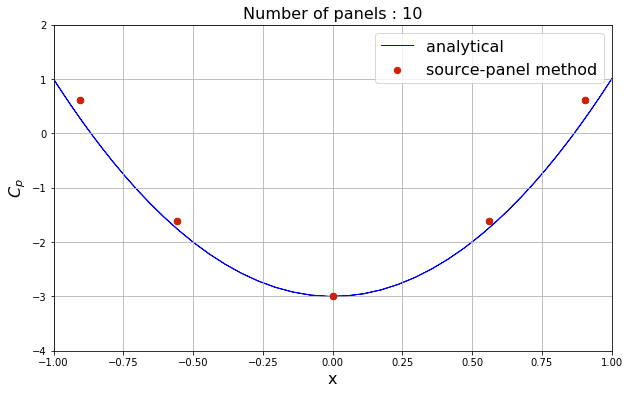

In [12]:
# calculate the analytical surface pressure coefficient
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plot the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(x_cylinder, cp_analytical,
            label='analytical',
            color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels],
               label='source-panel method',
               color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-1.0, 1.0)
pyplot.ylim(-4.0, 2.0);

##### Контрольное задание

Теперь, когда мы вычислили коэффициент давления на поверхности цилиндра, было бы интересно узнать, как ведут себя линии тока.

Для этого воспользуемся функцией `streamplot()` библиотеки Matplotlib, которой требуются декартовы компоненты скорости (`u`,`v`) в узлах расчетной сетки (`X`,`Y`). Поэтому, первый шаг — это вывести уравнения для компонент скорости.

Потенциал $N_p$ слоев источников в равномерном потоке в точке $\left(x,y\right)$ задается формулой

$$\phi\left(x,y\right) = U_\infty x + \sum_{j=1}^{N_p} \frac{\sigma_j}{4\pi} \int \ln \left( \left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2 \right) {\rm d}s_j$$

А поле скоростей в точке $\left(x,y\right)$:

$$u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

$$v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace$$

Ваша задача:

* определить компоненты скорости в декартовой системе координат
* создать сетку
* вычислить поле скоростей в каждом узле сетки
* нарисовать результат
* изменить количество панелей для улучшения визуализации

---

In [13]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()